In [47]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Models

In [7]:

def discretize_features(X, n_bins=10, strategy='uniform'):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    X_discretized = discretizer.fit_transform(X)
    return X_discretized



# JMI


In [8]:
def joint_mutual_information(X, y, k, n_bins=10, strategy='uniform'):
    X_discretized = discretize_features(X, n_bins=n_bins, strategy=strategy)
    
    n_samples, n_features = X_discretized.shape
    selected_features = []
    remaining_features = list(range(n_features))
    
    mutual_info = mutual_info_classif(X_discretized, y)
    first_feature = np.argmax(mutual_info)
    selected_features.append(first_feature)
    remaining_features.remove(first_feature)
    
    while len(selected_features) < k:
        max_jmi = -np.inf
        next_feature = -1
        
        for feature in remaining_features:
            jmi = 0
            for selected in selected_features:
                joint_mi = mutual_info_classif(X_discretized[:, [selected, feature]], y) 
                jmi += joint_mi[1]
            jmi /= len(selected_features)
            
            if jmi > max_jmi:
                max_jmi = jmi
                next_feature = feature
        
        selected_features.append(next_feature)
        remaining_features.remove(next_feature)
    
    return selected_features

# CMIM

In [24]:
def conditional_mutual_information_maximization(X, y, k, n_bins=10, strategy='uniform'):
    X_discretized = discretize_features(X, n_bins=n_bins, strategy=strategy)
    
    n_samples, n_features = X_discretized.shape
    selected_features = []
    remaining_features = list(range(n_features))
    mutual_info = mutual_info_classif(X_discretized, y)
    
    first_feature = np.argmax(mutual_info)
    selected_features.append(first_feature)
    remaining_features.remove(first_feature)
    
    while len(selected_features) < k:
        max_cmim = -np.inf
        next_feature = -1
        
        for feature in remaining_features:
            min_mi = np.inf
            for selected in selected_features:
                joint_mi = mutual_info_classif(X_discretized[:, [selected, feature]], y)
                min_mi = min(min_mi, joint_mi[1])
            
            if min_mi > max_cmim:
                max_cmim = min_mi
                next_feature = feature
        
        selected_features.append(next_feature)
        remaining_features.remove(next_feature)
    
    return selected_features

# Additional methods

In [61]:
def boruta(X, y, n_estimators=100, max_iter=100, verbose=0):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=verbose, max_iter=max_iter)
    boruta.fit(X, y)
    selected_features = np.where(boruta.support_ == True)[0]
    
    return selected_features

In [45]:
def random_forest_feature_selection(X, y, n_features, n_estimators=100):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rf.fit(X, y)
    importances = rf.feature_importances_
    selected_features = np.argsort(importances)[::-1][:n_features]
    
    return selected_features

# Artificial datasets

In [9]:
def create_synthetic_data(n_samples=1000, n_features=10, n_informative=3, noise=0.1):
    X = np.random.randn(n_samples, n_features)
    informative_indices = np.random.choice(n_features, n_informative, replace=False)
    
    y = np.sum(X[:, informative_indices], axis=1) + noise * np.random.randn(n_samples)
    y = (y > np.median(y)).astype(int)
    
    return X, y, informative_indices

In [185]:
import numpy as np

def create_synthetic_xor_data(n_samples=1000, n_features=10, n_informative_pairs=1, noise=0.1):
    X = np.random.randn(n_samples, n_features)
    informative_indices = np.random.choice(n_features, 2 * n_informative_pairs, replace=False)
    
    y = np.zeros(n_samples)
    for i in range(n_informative_pairs):
        idx1, idx2 = informative_indices[2*i], informative_indices[2*i + 1]
        xor_result = ((X[:, idx1] > 0) ^ (X[:, idx2] > 0)).astype(int)
        y += xor_result

    y = y + noise * np.random.randn(n_samples)
    y = (y > np.median(y)).astype(int)
    
    return X, y, informative_indices




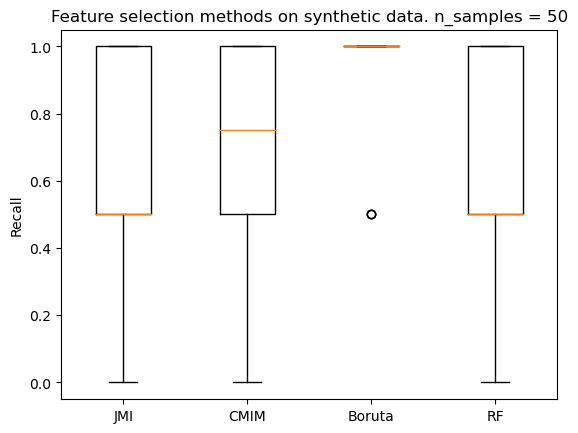

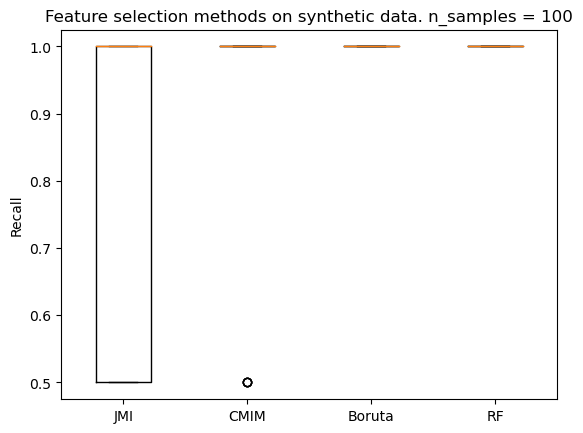

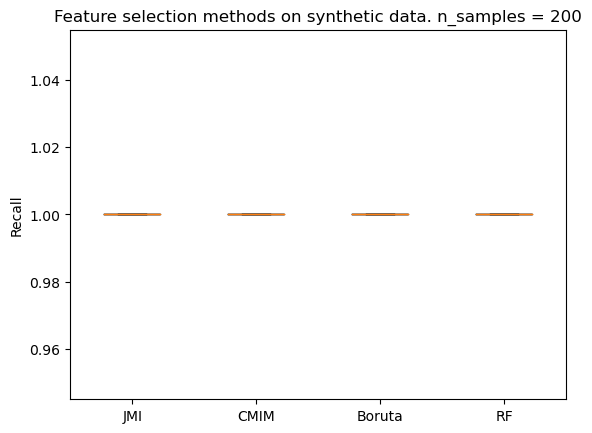

In [148]:
n_samples = [50, 100, 200]
n_experiements = 20

results = np.zeros((n_experiements, 4))
for l in n_samples:
    for n in range(n_experiements):
        X, y, informative_indices = create_synthetic_data(n_samples=l)
        n_features = X.shape[1]
        
        jmi_selected_features = joint_mutual_information(X, y, k=len(informative_indices))
        cmim_selected_features = conditional_mutual_information_maximization(X, y, k=len(informative_indices))
        boruta_selected_features = boruta(X, y)
        rf_selected_features = random_forest_feature_selection(X, y, n_features=len(informative_indices))
        
        jmi_recall = len(set(jmi_selected_features) & set(informative_indices)) / len(informative_indices)
        cmim_recall = len(set(cmim_selected_features) & set(informative_indices)) / len(informative_indices)
        boruta_recall = len(set(boruta_selected_features) & set(informative_indices)) / len(informative_indices)
        rf_recall = len(set(rf_selected_features) & set(informative_indices)) / len(informative_indices)
        
        results[n] = [jmi_recall, cmim_recall, boruta_recall, rf_recall]

    plt.boxplot(results, labels=['JMI', 'CMIM', 'Boruta', 'RF'])
    plt.ylabel('Recall')
    plt.title('Feature selection methods on synthetic data. n_samples = {}'.format(l))  
    plt.show()

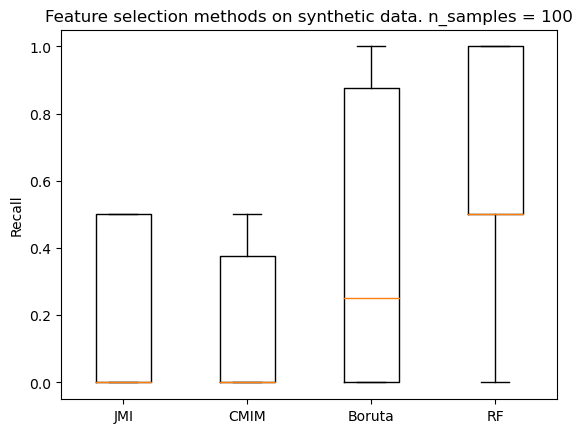

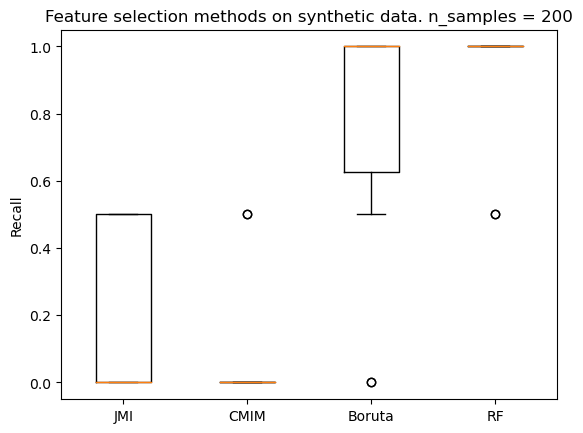

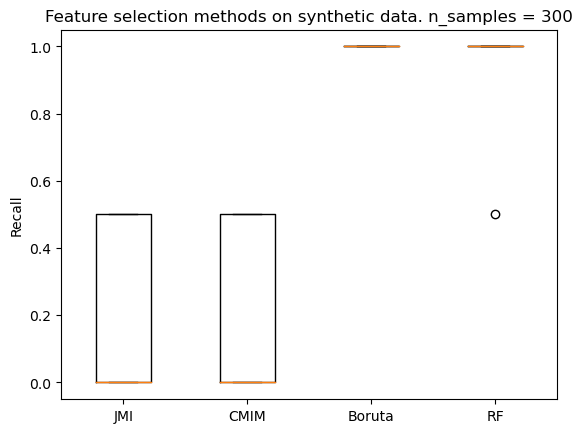

In [190]:
n_samples = [100, 200, 300]
n_experiements = 10

results = np.zeros((n_experiements, 4))
for l in n_samples:
    for n in range(n_experiements):
        X, y, informative_indices = create_synthetic_xor_data(n_samples=l)
        n_features = X.shape[1]
        
        jmi_selected_features = joint_mutual_information(X, y, k=len(informative_indices))
        cmim_selected_features = conditional_mutual_information_maximization(X, y, k=len(informative_indices))
        boruta_selected_features = boruta(X, y)
        rf_selected_features = random_forest_feature_selection(X, y, n_features=len(informative_indices))
        
        jmi_recall = len(set(jmi_selected_features) & set(informative_indices)) / len(informative_indices)
        cmim_recall = len(set(cmim_selected_features) & set(informative_indices)) / len(informative_indices)
        boruta_recall = len(set(boruta_selected_features) & set(informative_indices)) / len(informative_indices)
        rf_recall = len(set(rf_selected_features) & set(informative_indices)) / len(informative_indices)
        
        results[n] = [jmi_recall, cmim_recall, boruta_recall, rf_recall]

    plt.boxplot(results, labels=['JMI', 'CMIM', 'Boruta', 'RF'])
    plt.ylabel('Recall')
    plt.title('Feature selection methods on synthetic data. n_samples = {}'.format(l))  
    plt.show()

# Real word datasets

In [195]:
import numpy as np
from sklearn.datasets import load_breast_cancer, load_wine, load_diabetes, load_digits, load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

def evaluate_model(X_train, X_test, y_train, y_test, selected_features=None):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train[:, selected_features], y_train)
    y_pred = model.predict(X_test[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1    


In [156]:
def real_data_experiement(X, Y, title):
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

    precentage_of_features = [10, 30, 50, 70, 90]

    jmi_accuracies = []
    cmim_accuracies = []
    rf_accuracies = []

    for p in precentage_of_features:
        n_features = int(p / 100 * X.shape[1])
        
        selected_features_jmi = joint_mutual_information(X_train, y_train, k=n_features)
        accuracy = evaluate_model(X_train, X_test, y_train, y_test, selected_features_jmi)[0]
        jmi_accuracies.append(accuracy)
        
        selected_features_cmim = conditional_mutual_information_maximization(X_train, y_train, k=n_features)
        accuracy = evaluate_model(X_train, X_test, y_train, y_test, selected_features_cmim)[0]
        cmim_accuracies.append(accuracy)
        
        selected_features_rf = random_forest_feature_selection(X_train, y_train, n_features=n_features)
        accuracy = evaluate_model(X_train, X_test, y_train, y_test, selected_features_rf)[0]
        rf_accuracies.append(accuracy)
    
    selected_features_boruta = boruta(X_train, y_train)
    accuracy = evaluate_model(X_train, X_test, y_train, y_test, selected_features_boruta)[0]
    boruta_accuracies = accuracy
    boruta_p_precentage = len(selected_features_boruta) / X.shape[1] * 100

    plt.plot(precentage_of_features, jmi_accuracies, label='JMI', marker='o')
    plt.plot(precentage_of_features, cmim_accuracies, label='CMIM', marker='x')
    plt.plot(precentage_of_features, rf_accuracies, label='Random Forest', marker='d')
    plt.scatter([boruta_p_precentage], [boruta_accuracies], label='Boruta', marker='s', color='black')
    plt.xlabel('Percentage of Features')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()


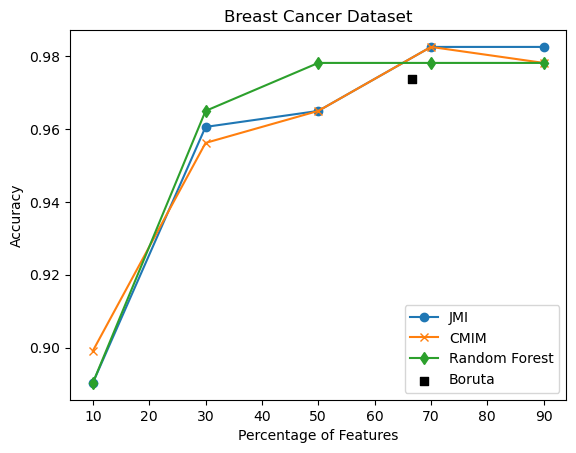

In [157]:
data = load_breast_cancer()
X, y = data.data, data.target

real_data_experiement(X, y, 'Breast Cancer Dataset')

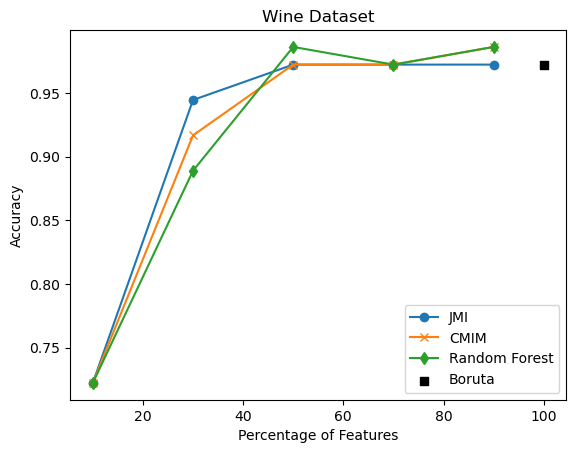

In [192]:
data = load_wine()
X, y = data.data, data.target

real_data_experiement(X, y, 'Wine Dataset')

/Users/szymonszmajdzinski/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymonszmajdzinski/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymonszmajdzinski/opt/anaconda3/envs/aml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

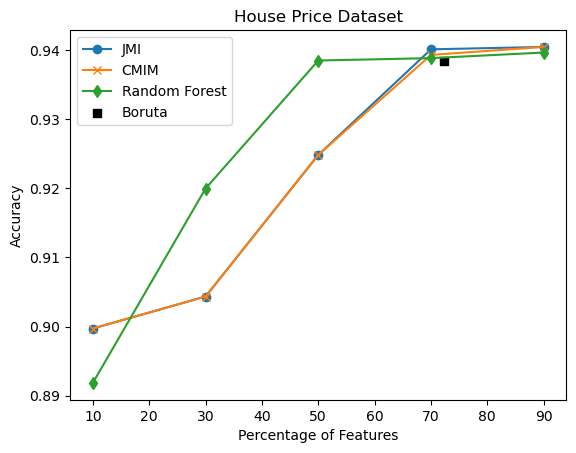

In [196]:
import pandas as pd 
df = pd.read_csv('house.csv')
y = df['price'].to_numpy().reshape(-1,1)
X = df.drop(columns=['price', 'id', 'date'])

y = discretize_features(y, n_bins=10, strategy='uniform')
y = y.ravel()


real_data_experiement(X, y, 'House Price Dataset')
